# End-to-End ML project: Housing prices. 

Adapted from Hands-on ml book by Aurelien Geron

The task here is to predict median house values in Californian districts, given a number of features from these districts.

In [1]:
# Initial Setup that is required for the project
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = ""


def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
from download_data import fetch_housing_data

# downloads the data and unzips it 
fetch_housing_data()

The data was downloaded to the following location: datasets/housing
Unzipping the file
Data downloading and unzipping complete!


In [3]:
from load_csv_using_panda import load_data

housing = load_data("datasets/housing/housing.csv")
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Understanding the data 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that there are 20640 instances in the data set. Also, we note that total_bedrooms column has only 20433 values, i.e. it has some null instances. One more observation here is that all the attributes are numerical except for ocean_proximity.

In [5]:
# exploring the data under ocean_proximity. It turns out that this is categorical attribute.
# To find out all the values of this category we can use values_counts()
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
#We can also look at the details of other attributes using the describe()
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Saving figure attribute_histogram_plots


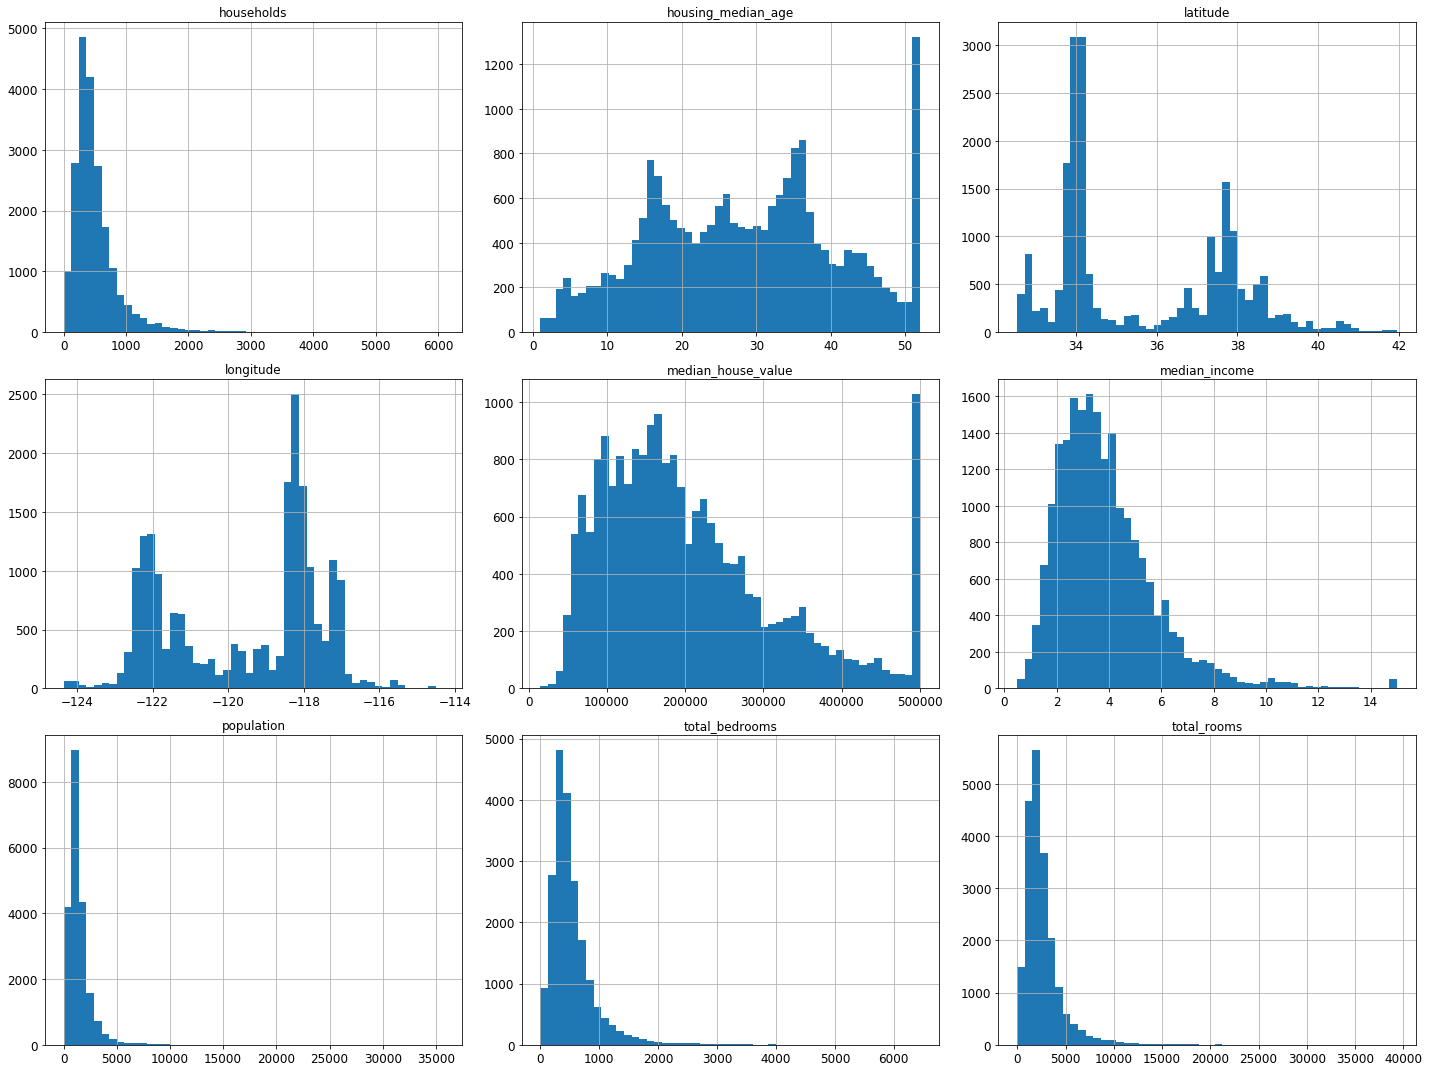

In [7]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

The data above indicates a few problems that we will take care in the further steps. For instance, many of the histograms above are tail heavy, some of the attributes have values that are capped such as median_income and housing_median_age. 

## Creating a test and train split

In [8]:
#Creation of test set using a simple numpy permutation()
from simple_seed_based_split import split_train_test

train_set, test_set = split_train_test(housing, 0.2, 42)
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape) 

Training set :  (16512, 10) 
 Test set : (4128, 10)


In [9]:
#Creating a test set using hashing function 
# This method will break if the dataset changes
# here we compute hash of every instance and then store the last byte of the hash
#

import hashlib

def test_set_check(identifier, test_ratio, hash):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    tset_set_indexes = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[-tset_set_indexes], data.loc[tset_set_indexes]

#for the above code to run we would need to create a unique identifier for the dataset.
# solution 1: use the row index as unique identifier
housing_with_id = housing.reset_index() # adds and 'index' column
# issue with above solution? We always have to append an entry at the bottom of the set
# and we will to also ensure that no row ever gets deleted
housing_with_id.describe()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape)

Training set :  (16362, 11) 
 Test set : (4278, 11)


In [10]:
# To avoid the complicated situation above, we can create a custom unique identifier
# We will build one using the latitude and longitude

housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape) 

Training set :  (16267, 12) 
 Test set : (4373, 12)


In [11]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [12]:
#Using sckitlearn to split test and train set
# This is particularaly useful if you have a separate data frame for labels. 
# Using the same seed value will generate same index samples across multiple data frames

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print ("Training set : ",train_set.shape,"\n","Test set :", test_set.shape)

Training set :  (16512, 10) 
 Test set : (4128, 10)


## How to ensure that the test set, is a good representation of an important feature?

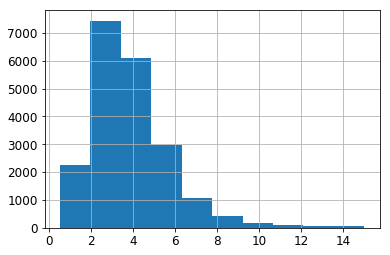

In [13]:
# According to the experts, median_income is an important feature.
# We have to ensure that the test set consists of all the categories of this feature
# If you see, this feature is a numerical feature --> we convert it to income category attribute
housing["median_income"].hist()

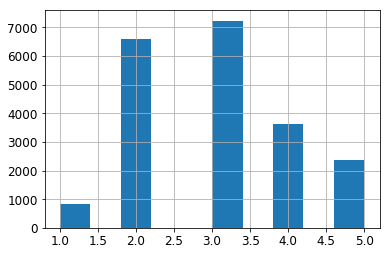

In [14]:
# we can observe more values that lie in the range 2-5. 
#The important thing is to have sufficient number of instances in each stratum
# or else the stratums importance maybe biased
# Also, we need to reduce the number of stratums that we create.

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
#merging all the values greater than 5 to 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"].hist()

In [15]:
#Now we are ready to do a stratified smapling based on the income category

from sklearn.cross_validation import StratifiedShuffleSplit

split = StratifiedShuffleSplit(housing["income_cat"], test_size=0.2)
train_indices, test_indices = next(iter(split))
strat_train_set = housing.loc[train_indices]
strat_test_set = housing.loc[test_indices]
print ("Training set : ",strat_train_set.shape,"\n","Test set :", strat_test_set.shape)

Training set :  (16512, 11) 
 Test set : (4128, 11)


/Users/hseth/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [16]:
#checking the distribution of the income_cat
housing["income_cat"].value_counts()/ len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [17]:
# Measuring the income_cat protions in test set with Stratified sampling vs test set with random sampling
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# consolidating the proportions of income_cat in both the data set
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

#calculating the error percentage in each proportion for both the test_sets
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [18]:
compare_props

#The below table shows that income_cat proportions in stratified sampline are closer to the overall dataset,
#as compared to random sampling.

,Overall,Random,Stratified,Rand. %error,Strat. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


### How to remove a feature coloumn from the pandas data frame?

In [19]:
strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat
count,16512.000000,16512.000000,16512.000000,16512.000000,16339.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.560879,35.622173,28.725896,2635.008842,537.480935,1424.421330,499.434835,3.867396,206624.537306,3.006541
std,2.001267,2.130831,12.573075,2176.523055,421.014956,1124.810518,381.650990,1.890169,115081.918196,1.054602
min,-124.300000,32.540000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000,1.000000
25%,-121.790000,33.930000,18.000000,1445.750000,295.000000,789.750000,280.000000,2.563400,119400.000000,2.000000
50%,-118.480000,34.250000,29.000000,2130.000000,435.000000,1167.000000,409.000000,3.539100,179750.000000,3.000000
75%,-118.000000,37.710000,37.000000,3145.250000,647.000000,1727.000000,603.000000,4.744700,263900.000000,4.000000
max,-114.470000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,5.000000


In [20]:
strat_train_set.describe()
#restoring the data set, remvoing the income_cat feature

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

strat_train_set.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,16512.000000,16512.000000,16512.000000,16512.000000,16339.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.560879,35.622173,28.725896,2635.008842,537.480935,1424.421330,499.434835,3.867396,206624.537306
std,2.001267,2.130831,12.573075,2176.523055,421.014956,1124.810518,381.650990,1.890169,115081.918196
min,-124.300000,32.540000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1445.750000,295.000000,789.750000,280.000000,2.563400,119400.000000
50%,-118.480000,34.250000,29.000000,2130.000000,435.000000,1167.000000,409.000000,3.539100,179750.000000
75%,-118.000000,37.710000,37.000000,3145.250000,647.000000,1727.000000,603.000000,4.744700,263900.000000
max,-114.470000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000


## Gaining insights to the training set data

### Making a copy of the training set, for exploration

In [21]:
housing = strat_train_set.copy()

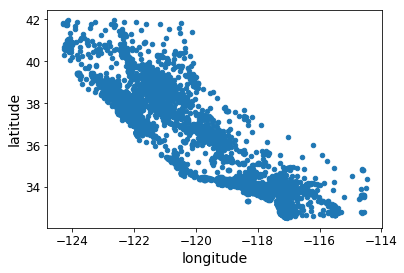

In [22]:
# Visualizing the data geographically, since we have latitude and longitudes present
housing.plot(kind="scatter", x="longitude", y="latitude")


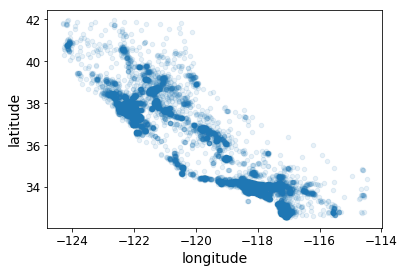

In [23]:
# since, the above graph roughly represents California but it does not help us in identifying patterns
# we will highlight dense areas, in order to get some patterns

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

#the below map represents densely populated areas, such as bay area and california

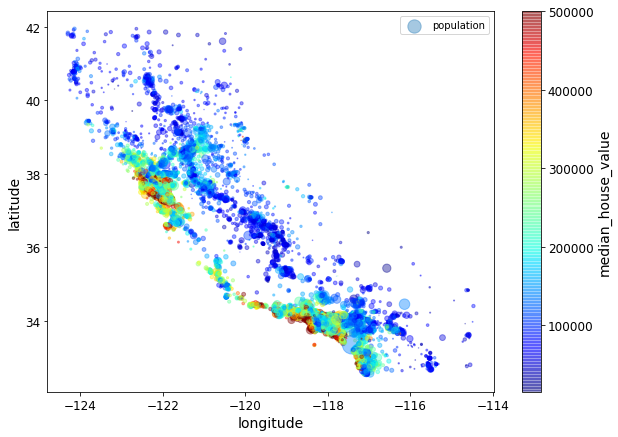

In [24]:
# To look at the housing prices, we also include other attributes of the dataset
# We use population to represent the redius of the circle
# Color represent the prices, i.e blue is lower values and red is higher

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

#We can see from the map below that housing prices are closely related to either the location or population
# We can then use a clustering alogrithm to identify important clusters and use them as features

## Finding the correlation in the data

### Method 1: Using corr()

In [25]:
# Calculating the standard coefficient correlation (Pearson's correlation) between all the attributes of the dataset
# The values range from -1 to 1. Positive values indicates a direct porportional relation
# A negative values indicates an inverse relation .Zero indcates no relation.
# We only focus on the absoulte values, higher the values stronger the relation.
# Note: This formula only talks about linear relation between the attributes

corr_matrix = housing.corr()

corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.925902,-0.108155,0.045174,0.069063,0.101354,0.055134,-0.015607,-0.044848
latitude,-0.925902,1.000000,0.012711,-0.033715,-0.063736,-0.107254,-0.068172,-0.078512,-0.144215
housing_median_age,-0.108155,0.012711,1.000000,-0.364203,-0.322185,-0.298434,-0.305285,-0.123259,0.100349
total_rooms,0.045174,-0.033715,-0.364203,1.000000,0.930187,0.854848,0.918126,0.200323,0.134736
total_bedrooms,0.069063,-0.063736,-0.322185,0.930187,1.000000,0.873633,0.978954,-0.006326,0.048853
population,0.101354,-0.107254,-0.298434,0.854848,0.873633,1.000000,0.904459,0.009065,-0.023135
households,0.055134,-0.068172,-0.305285,0.918126,0.978954,0.904459,1.000000,0.015353,0.066135
median_income,-0.015607,-0.078512,-0.123259,0.200323,-0.006326,0.009065,0.015353,1.000000,0.687444
median_house_value,-0.044848,-0.144215,0.100349,0.134736,0.048853,-0.023135,0.066135,0.687444,1.000000


In [26]:
# Observing the correlation of attributes w.r.t to median housing value <the target>
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687444
total_rooms           0.134736
housing_median_age    0.100349
households            0.066135
total_bedrooms        0.048853
population           -0.023135
longitude            -0.044848
latitude             -0.144215
Name: median_house_value, dtype: float64

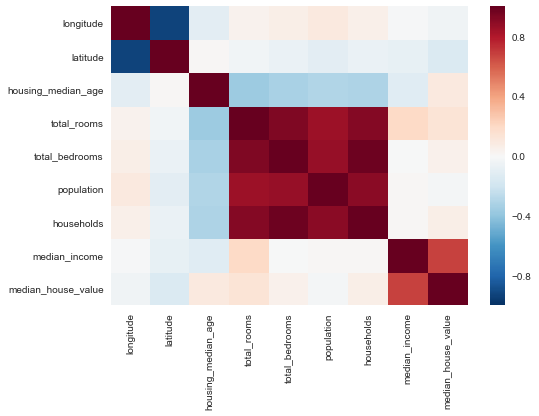

In [27]:
import seaborn as sns
corr = housing.corr()
sns.heatmap(corr,
           xticklabels = corr.columns.values,
           yticklabels = corr.columns.values)
#From the heatmap we can visually see the relation  between median house value and median income is higher

### Method 2: Using scatter plot from pandas

Saving figure scatter_matrix_plot


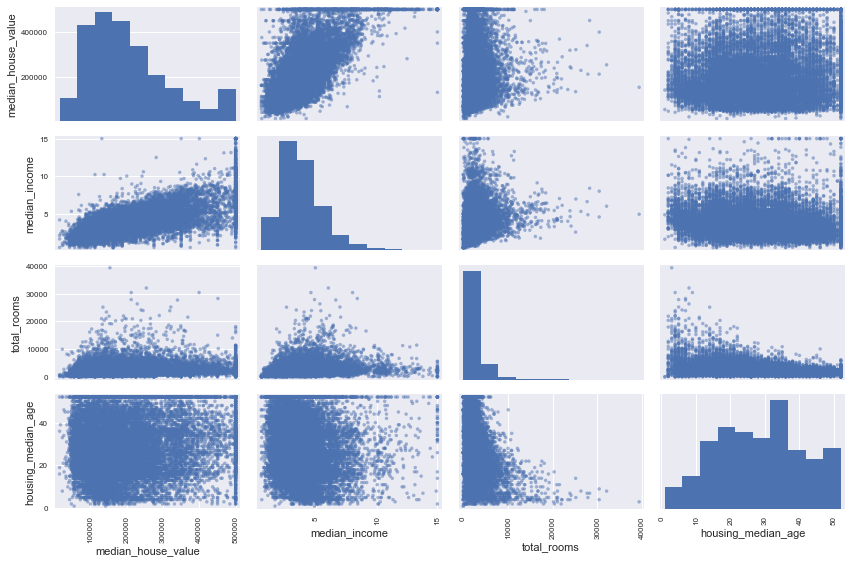

In [28]:
# We can use scatter plots to plot each numerical attribute against the other 
# i.e 11 numerical attributes would give 121 plots, which will not fit on one page
# Instead we will focus on top 4 most correlated attributes w.r.t median house value


from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

# The diagonal plots are suppose to be straight lines, as each data would be highly correlated to itself
# but Pandas instead plots the histogram of each attribute


Saving figure income_vs_house_value_scatterplot


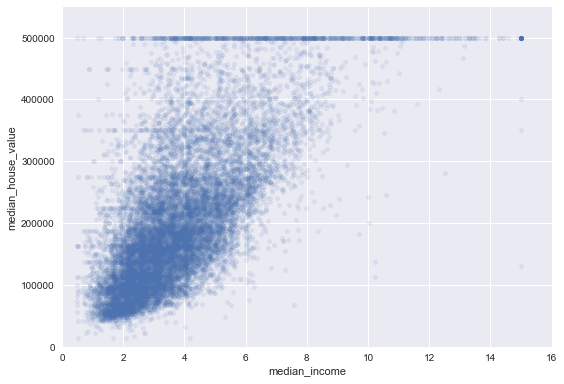

In [29]:
# Zooming on the most correlated feature of median housing value i.e median income

housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

 In the plot above, we can observe the following
 1. The is strong relation and points are not dispersed
 2. There is prices cap that can be at 50000 line 
 3. There are some less obvious straight lines too
 		
       a. Lines around the following values $450k, $350k, $280k.
 
We can try removing the corresponding districts to prevent our algo from learning these data quirks

## Experimenting with attributes combination or feature combination

In [30]:
# Some of the features alone, don't provide any contirbution. 
# E.g total rooms in a district does not really convey any message
# Instead combining total rooms with household, gives number of rooms per household which might be correlated
# Try to build such combination attributes.

housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16339.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16339.000000,16512.000000
mean,-119.560879,35.622173,28.725896,2635.008842,537.480935,1424.421330,499.434835,3.867396,206624.537306,5.423534,0.213152,3.098792
std,2.001267,2.130831,12.573075,2176.523055,421.014956,1124.810518,381.650990,1.890169,115081.918196,2.565389,0.058324,11.587241
min,-124.300000,32.540000,1.000000,2.000000,1.000000,5.000000,1.000000,0.499900,14999.000000,0.846154,0.100000,0.692308
25%,-121.790000,33.930000,18.000000,1445.750000,295.000000,789.750000,280.000000,2.563400,119400.000000,4.442904,0.175620,2.430375
50%,-118.480000,34.250000,29.000000,2130.000000,435.000000,1167.000000,409.000000,3.539100,179750.000000,5.221658,0.203184,2.820830
75%,-118.000000,37.710000,37.000000,3145.250000,647.000000,1727.000000,603.000000,4.744700,263900.000000,6.045906,0.239656,3.279945
max,-114.470000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


In [31]:

# calcuating the correlation of the new attributes
corr_mat = housing.corr()
corr_mat["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687444
rooms_per_household         0.146066
total_rooms                 0.134736
housing_median_age          0.100349
households                  0.066135
total_bedrooms              0.048853
population_per_household   -0.021676
population                 -0.023135
longitude                  -0.044848
latitude                   -0.144215
bedrooms_per_room          -0.255089
Name: median_house_value, dtype: float64

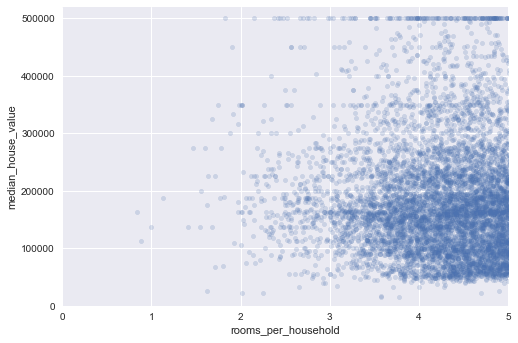

In [32]:
# We can observe that rooms per household has a better corelation with median house value.
# Plotting the two attributes, on a scatter plot

housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

## Prepare the data for machine learning algorithms

In [33]:
# Create a copy of the data i.e training set and separate the features and labels
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

## Handling missing values 

In [34]:
# Getting the missing values for experimentation
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
16105,-122.50,37.75,44.0,1819.0,NaN,1137.0,354.0,3.4919,NEAR OCEAN
9970,-122.48,38.50,37.0,3049.0,NaN,1287.0,439.0,4.3125,INLAND
4046,-118.49,34.13,24.0,4394.0,NaN,1443.0,528.0,11.2979,<1H OCEAN
13332,-117.65,34.04,15.0,3393.0,NaN,2039.0,611.0,3.9336,INLAND
19766,-122.10,40.03,25.0,2516.0,NaN,1266.0,494.0,1.7566,INLAND


### Option 1: Getting rid of those particular instances, which contain missing values

In [35]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


### Option 2: Removing the attribute completely

In [36]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)  

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
16105,-122.50,37.75,44.0,1819.0,1137.0,354.0,3.4919,NEAR OCEAN
9970,-122.48,38.50,37.0,3049.0,1287.0,439.0,4.3125,INLAND
4046,-118.49,34.13,24.0,4394.0,1443.0,528.0,11.2979,<1H OCEAN
13332,-117.65,34.04,15.0,3393.0,2039.0,611.0,3.9336,INLAND
19766,-122.10,40.03,25.0,2516.0,1266.0,494.0,1.7566,INLAND


###  Option 3: Fill those with some value. (Median in this case)

In [37]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
16105,-122.50,37.75,44.0,1819.0,435.0,1137.0,354.0,3.4919,NEAR OCEAN
9970,-122.48,38.50,37.0,3049.0,435.0,1287.0,439.0,4.3125,INLAND
4046,-118.49,34.13,24.0,4394.0,435.0,1443.0,528.0,11.2979,<1H OCEAN
13332,-117.65,34.04,15.0,3393.0,435.0,2039.0,611.0,3.9336,INLAND
19766,-122.10,40.03,25.0,2516.0,435.0,1266.0,494.0,1.7566,INLAND


<span style="color:blue">Note: when filling the instances with missing values do not forget to save these values, as we will need these values to fill missing values in the test set</span>

### Creating an imputer class

In [38]:
# We will make use of the sci-kit learn's imputer class. 
# Creating this class is handy as it can be reused to transform the both the test and training data.
# It can also be resused accross other datasets.


from sklearn.preprocessing import Imputer
# We select the median stratergy to fill the missing values
imputer = Imputer(strategy="median")

In [39]:
# Since the median can only be calculated for numerical attributes, we have to remove the textual featuers
housing_num = housing.drop("ocean_proximity", axis =1)

In [40]:
# We can now fit the imputer instance over the training data
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy=u'median',
    verbose=0)

In [41]:
# The imputer will store all the median values for all the features in statistics_
imputer.statistics_

array([ -118.48  ,    34.25  ,    29.    ,  2130.    ,   435.    ,
        1167.    ,   409.    ,     3.5391])

We can cross check that this is same as calculating median of all the features ourselves. 

In [42]:
housing_num.median().values

array([ -118.48  ,    34.25  ,    29.    ,  2130.    ,   435.    ,
        1167.    ,   409.    ,     3.5391])

After the model goes live, it could be possible that there would be missing values for attributes other than total bedrooms. Hence, we have trained the imputer class accross all the numerical attributes.

Now we will use this "trained" imputer class to transform the missing values in the training set

In [43]:
X = imputer.transform(housing_num)
X.shape

(16512, 8)

In [44]:
# Since X here is numpy array we can convert to pandas dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [45]:
# Verifying the missing values have gotten transformed
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
16105,-122.50,37.75,44.0,1819.0,435.0,1137.0,354.0,3.4919
9970,-122.48,38.50,37.0,3049.0,435.0,1287.0,439.0,4.3125
4046,-118.49,34.13,24.0,4394.0,435.0,1443.0,528.0,11.2979
13332,-117.65,34.04,15.0,3393.0,435.0,2039.0,611.0,3.9336
19766,-122.10,40.03,25.0,2516.0,435.0,1266.0,494.0,1.7566


In [46]:
# converting to a dataframe
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.58,39.50,29.0,1947.0,383.0,925.0,337.0,2.1658
1,-119.25,34.28,36.0,2232.0,373.0,951.0,368.0,5.2261
2,-120.45,34.96,21.0,2121.0,445.0,2211.0,463.0,4.0603
3,-118.29,34.00,44.0,1753.0,387.0,1165.0,380.0,2.1354
4,-119.85,36.75,24.0,1143.0,245.0,608.0,240.0,2.8194


## Handling textual or categorical attributes

Since we cannot take the mean of the a textual / categorical attribute, we first have to convert into a numerical attribute for us use as most of the ML algorithms work on numerical attributes. 

In [47]:
# Option 1: Use a LabelEncoder. 

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

#We can observe that it has encoded each category to an number between 0..n

array([1, 4, 0, ..., 0, 1, 3])

In [48]:
# To understand the conversion, we can decode the labeling
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


<span style="color:blue">Note: an issue with using LabelEncoder for categorical attributes is that ML algorithms will assume two nearby values to be more similar than two distant values, which is not the case for categorical attributes.</span>

In [49]:
# Option 2: One hot encoding.
# In this we create a binary attribute for each distinct category.
# Here only one attribute will be 1 (hot), whereas the rest of the values would be cold (0)

from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
# the fit_transform() expects a 2d array but our housing_cat_encoded is a 1d array, so we reshape it
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
# the output is a sci-py's sparse matrix
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

<span style="color:blue">Note: To convert a 1d array to 2d array, we used reshape(). This function allows a dimension to be written as -1, which means "unspecified" : the value is infered from length of the array and remaning dimensions</span>

In [50]:
# to convert a sparse matrix to a numpy array to toarray()
housing_cat_1hot.toarray()

array([[ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

In [51]:
# Option 3: LabelBinarizer
# Instead of a two step process: 1. Convert to categories to numerical attributes 2. One hot encoding
# We can now use a LabelBinarizer which does this for us

from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

# This by default returns a dense matrix
# We can get a sparse matrix using the encoder below
#encoder = LabelBinarizer(sparse_output= True)


array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       ..., 
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0]])

## Custom Transorfmer

We can build our own custom transformers or clean up utilities to be used with Pipelines.
<span style="color:blue">We can use these add features as hyperparameters.</span>


In [52]:
# We can try to build a transformer for adding combined attributes.

from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    #adding a bedrooms per room as a hyper param
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [53]:
# Testing out the new custom transformer

housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.58,39.5,29,1947,383,925,337,2.1658,INLAND,5.77745,2.74481
1,-119.25,34.28,36,2232,373,951,368,5.2261,NEAR OCEAN,6.06522,2.58424
2,-120.45,34.96,21,2121,445,2211,463,4.0603,<1H OCEAN,4.58099,4.77538
3,-118.29,34,44,1753,387,1165,380,2.1354,<1H OCEAN,4.61316,3.06579
4,-119.85,36.75,24,1143,245,608,240,2.8194,INLAND,4.7625,2.53333


In [54]:
housing_extra_attribs.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
count,16512.0,16512.00,16512.0,16512.0,16339.0,16512.0,16512.0,16512.000,16512,16512.0,16512.0
unique,819.0,841.00,52.0,5481.0,1816.0,3617.0,1701.0,10951.000,5,15653.0,15313.0
top,-118.3,34.06,52.0,1650.0,331.0,1227.0,429.0,2.875,<1H OCEAN,5.0,3.0
freq,126.0,211.00,1034.0,14.0,46.0,20.0,48.0,38.000,7309,23.0,28.0


## Transformation Pipelines

In [55]:
# We can combine all the different transformation steps into a single pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])
# Note: We are passing housing_num through the transformer pipeline as all the functions 
# only operate on numerical feat.
housing_num_tr = num_pipeline.fit_transform(housing_num)

In the pipeline, we have added a StandardScaler transformation. This is for feature scaling. In this, we subtract the mean value and then divide it by variance. Due to this, the resulting distribution has unit variance.

<span style="color:blue">Note: While building a Pipeline class, all but the last steps must be transformers. (i.e they must have fit_transform() except for the last step.</span>

In [56]:
housing_num_tr

array([[-1.00895168,  1.81992137,  0.02180151, ...,  0.1379615 ,
        -0.03055046, -0.25957718],
       [ 0.15534597, -0.62990155,  0.57856364, ...,  0.25013865,
        -0.04440819, -0.70505768],
       [-0.4442923 , -0.31076753, -0.61449807, ..., -0.32843592,
         0.14469681, -0.06250321],
       ..., 
       [ 0.6650385 , -0.80824115,  0.41948874, ..., -0.20237365,
         0.13382456,  0.16036259],
       [-0.08450934,  0.53399899,  0.10133895, ..., -0.17387439,
        -0.02156897, -0.47845311],
       [-1.35374369,  1.11594927, -1.09172276, ...,  0.54883273,
         0.00989836, -1.1656394 ]])

We have built a pipeline for all the numercial data but we also need a set of transformations for our categorical features, like we experimented previously. How to join a LabelBinarizer into a single pipeline? Using FeatureUnion!

In [57]:
# First we need to convert Pandas dataframe into a numpy array. Let's build a transformer for it

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values



In [58]:
# Identifying all the attribute names
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Building a numerical attributes pipeline
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# Building a categorical attribtues pipeline
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])


In [59]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [60]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.00895168,  1.81992137,  0.02180151, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.15534597, -0.62990155,  0.57856364, ...,  0.        ,
         0.        ,  1.        ],
       [-0.4442923 , -0.31076753, -0.61449807, ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.6650385 , -0.80824115,  0.41948874, ...,  0.        ,
         0.        ,  0.        ],
       [-0.08450934,  0.53399899,  0.10133895, ...,  0.        ,
         0.        ,  0.        ],
       [-1.35374369,  1.11594927, -1.09172276, ...,  0.        ,
         1.        ,  0.        ]])

In [61]:
housing_prepared.shape

(16512, 16)

## Model selection and training

### Linear Regression model

In [62]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [67]:
# Let us try on sampel data from training set.

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [  64248.04188963  307148.35388781  221228.5094493   167849.26102318
  109669.54202577]


In [68]:
# Comparing against true values

print("Labels:", list(some_labels))

Labels: [57600.0, 303200.0, 117600.0, 105800.0, 81100.0]


We will try to measure the error i.e RMS, on the whole training set 

In [69]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68272.955979755425

Our values for median housing values ranges from 120,000 to 260,000. This means that we have prediction error of $68,273 which is not really good. This indiciates that we are underfitting the data. 

In [70]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49316.497146557544

### How to deal with underfitting?

1. Select a more powerful algorithm
2. Select better features or add more features
3. Reduce the constraint on the model i.e fix or reduce regularization param


In [73]:
# Trying option 1 from above. Using a decision tree regressor
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=42,
           splitter='best')

In [74]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

The above evalution shows that we have prefectly predicted everything on the training set, which also means that we might be overfitting the data, but to better evalute our model we will try and to a K-fold cross validation

### K-fold cross validation

In [76]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [78]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 72631.98548866  72742.8392009   75951.77580556  69546.54151803
  65170.31882877  68343.24021897  71158.42509288  69104.89719457
  73563.8706243   70161.88302923]
Mean: 70837.5777002
Standard deviation: 2898.37232164


If you now see the mean of the scores, you will realize that decision tree actually preforms worse than Linear Regression model. The cross-validation not only allows you to evalute your model but also provides a measure on how precise the measure is i.e standard deviation. The decision tree has score of approx 70837 with + - of 2898. 

In [79]:
# Cross validation the linear regression model

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 68777.43510234  69616.62345799  70299.13297112  69637.03303107
  73255.64341993  67151.3637321   68130.81645968  65636.40211076
  67267.31394366  67654.34776297]
Mean: 68742.6111992
Standard deviation: 2006.76445809


We can now conclude that the Decision tree was overfitting the training set so badly that it performs worse than a Linear Regression model.

In [80]:
# Expreimenting with a Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor


forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [82]:
# Calculating the training set error

housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22235.512184641091

In [83]:
# Performing cross validation on Random forest

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 51554.95252614  52278.56859506  53829.92088026  50386.75058824
  51802.67154938  51393.25032074  54853.70924441  51287.09249975
  51744.18074486  52197.91486003]
Mean: 52132.9011809
Standard deviation: 1233.44296987


The Random Forest model seem to work a better compared to the other two.

<span style="color:blue">Note: The score on the training set is still much lower than that on validation set, meaning the model is still overfitting the training set.</span>

### How to handle overffitting?

1. Simplify the model
2. Constrain it (i.e regularize it)
3. Add more training data

In [84]:
# Trying a SVM model with linear kernel

from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel=u'linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [85]:
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

110362.23614084942

In [86]:
svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)

svm_rmse_scores = np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)

Scores: [ 113564.04065012  110103.42074259  109668.22635274  113567.36659225
  108879.70152629  111330.02896723  111216.23232534  111099.14817202
  109017.23348349  112136.34039824]
Mean: 111058.173921
Standard deviation: 1599.78477024


The SVM model with linear kernel does not perform well on the data.